In [1]:
import pandas as pd
import os
csv_files = ['/kaggle/input/ecg-data/' + file for file in os.listdir('/kaggle/input/ecg-data') if file.endswith('.csv')]
dataframes = []
for file in csv_files:
    df_name = os.path.splitext(os.path.basename(file))[0]
    data = pd.read_csv(file)
    dataframes.append(data)

In [2]:
df = pd.concat(dataframes, ignore_index=True)
#df

In [3]:
df = df.dropna(subset=['Time', 'Raw', 'Label'])

In [4]:
df.drop(['Time'], axis = 1, inplace = True)

In [5]:
from sklearn.preprocessing import RobustScaler
df['Raw'] = RobustScaler().fit_transform(df['Raw'].to_numpy().reshape(-1,1))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
data = df.sample(frac = 0.1,random_state=1)

In [7]:
peak = data[data['Label']==1]
not_peak = data[data['Label']==0]
outlier_fraction = len(peak)/float(len(not_peak))

print("Peak : {}".format(len(peak)))
print("Not Peak : {}".format(len(not_peak)))
print("Outlier Fraction : {}".format(outlier_fraction))

Peak : 4497
Not Peak : 2895481
Outlier Fraction : 0.0015531098287296654


In [8]:
X = data.iloc[:,:1]
Y = data.iloc[:,-1]

In [9]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
import numpy as np
# Reshape the data for LSTM (sequence length, features)
sequence_length = 100  
num_samples_train = len(X_train) - sequence_length + 1
num_samples_test = len(X_test) - sequence_length + 1

X_train_reshaped = np.array([X_train[i:i+sequence_length] for i in range(num_samples_train)])
y_train_reshaped = y_train[sequence_length - 1:]

X_test_reshaped = np.array([X_test[i:i+sequence_length] for i in range(num_samples_test)])
y_test_reshaped = y_test[sequence_length - 1:]

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, 1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [12]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [14]:
# Train the model
model.fit(X_train_reshaped, y_train_reshaped, batch_size=128, epochs=5, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/5
16312/16312 [==============================] - 228s 13ms/step - loss: 0.0110 - accuracy: 0.9984 - val_loss: 0.0109 - val_accuracy: 0.9984
Epoch 2/5
16312/16312 [==============================] - 219s 13ms/step - loss: 0.0104 - accuracy: 0.9985 - val_loss: 0.0108 - val_accuracy: 0.9984
Epoch 3/5
16312/16312 [==============================] - 218s 13ms/step - loss: 0.0104 - accuracy: 0.9985 - val_loss: 0.0107 - val_accuracy: 0.9984
Epoch 4/5
16312/16312 [==============================] - 217s 13ms/step - loss: 0.0103 - accuracy: 0.9985 - val_loss: 0.0106 - val_accuracy: 0.9984
Epoch 5/5
16312/16312 [==============================] - 216s 13ms/step - loss: 0.0103 - accuracy: 0.9985 - val_loss: 0.0106 - val_accuracy: 0.9984


In [15]:
test_predictions = model.predict(X_test_reshaped)

18122/18122 [==============================] - 86s 5ms/step


In [16]:
# Assuming you have the predicted probabilities
threshold = 0.5  # Adjust as needed

binary_predictions = (test_predictions > threshold).astype(int)

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test_reshaped, binary_predictions))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    578960
         1.0       0.00      0.00      0.00       937

    accuracy                           1.00    579897
   macro avg       0.50      0.50      0.50    579897
weighted avg       1.00      1.00      1.00    579897



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, roc_curve, auc
import matplotlib.pyplot as plt
roc_auc = roc_auc_score(y_test_reshaped, binary_predictions)
mcc_score = matthews_corrcoef(y_test_reshaped, binary_predictions)
print("ROC-AUC score", roc_auc)
print("Matthews Correlation Coefficient:", mcc_score)

ROC-AUC score 0.5
Matthews Correlation Coefficient: 0.0


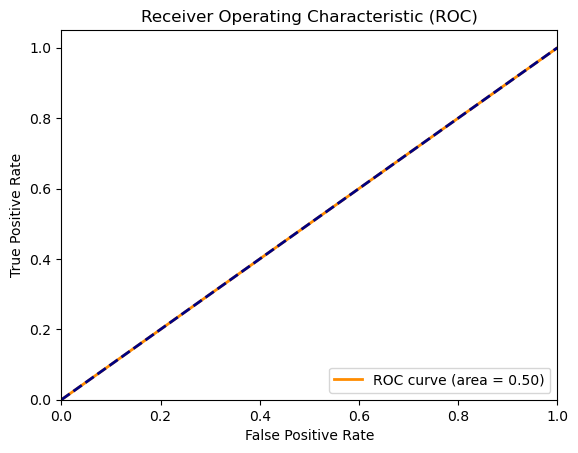

In [20]:
fpr, tpr, thresholds = roc_curve(y_test_reshaped, binary_predictions)
roc_curve = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_curve)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

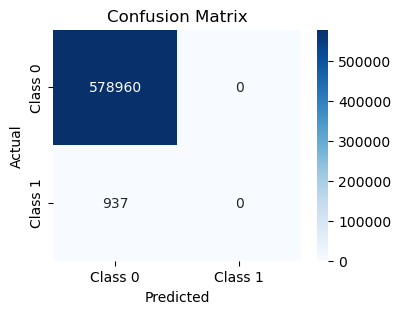

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Compute the confusion matrix
cm = confusion_matrix(y_test_reshaped, binary_predictions)

# Define class labels (modify if needed)
class_labels = ['Class 0', 'Class 1']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()